In [2]:
from earlyexitnet.training_tools.train import get_model
from earlyexitnet.tools import load_model, CIFAR10DataColl
import torch

model_path = '../../trained_models/b_lenet_cifar10.pth'
model_name = "b_lenet_cifar"

# model_path = '../../earlyexitnet/trained_models/resnet8_2ee_230721.pth'
# model_name = "resnet8_2ee"
model = get_model(model_name)
load_model(model, model_path,device=torch.device('cuda:0'))

Model done: b_lenet_cifar


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
#plt.switch_backend('WebAgg')
#%matplotlib widget
import numpy as np

BATCH_SIZE = 1000

datacoll = CIFAR10DataColl(batch_size_train=BATCH_SIZE, v_split=0.2)

from earlyexitnet.testing_tools.test import Tester
import json
from datetime import datetime as dt


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def compute_and_savevalues():
    # shorthand fn for running testing funcs on model
    # BUT using training data instead of test data
    train_dl = datacoll.get_train_dl() # get dataloader
    # create test obj for doing the conf tests and getting the stats
    tester = Tester(model, train_dl, exits=2, 
                    conf_funcs=[0,1,2,3,4], 
                    top1acc_thresholds=[0.6,0],
                    entropy_thresholds=[0.025, 1000000],
                    device=torch.device('cuda:0'), save_raw=True)
    # run tests
    tester.test()
    # pull results dict
    test_res = tester.get_stats()
    # get timestamp
    ts = dt.now().strftime("%Y-%m-%d_%H%M%S")
    # save the results to a json file
    with open(f'../../model-outputs/{model_name}_cifar10_raw_train_output_{ts}.json','a') as file:
        file.write(json.dumps(test_res))
    return test_res

In [ ]:
import json
loadFromFile = False
# compute the results using the loaded model or load them from a file
if loadFromFile:
  json_file = '../../model-outputs/resnet8_2ee_cifar10_raw_train_output_280723-12-18.json'
  with open(json_file) as json_data:
    test_res = json.load(json_data)
else:
  test_res = compute_and_savevalues()  

# load the raw outputs from the model
raw_results = torch.Tensor(test_res['raw_layer'])
# load the ground truth index for each class
correct_indices = torch.Tensor(test_res['true_indices'])

# compare the results to the ground truth, provides bool mask
correct_predictions = (raw_results.argmax(-1) == correct_indices)
# 2 exits by num inputs, 2 exits by num samples by last linear layer output(NOT sftmax)
correct_predictions.shape, raw_results.shape

In [4]:
train_dl = datacoll.get_train_dl() # get dataloader

tester = Tester(model, train_dl, exits=2, 
                conf_funcs=[0,1,2,3,4], 
                top1acc_thresholds=[0.6,0],
                entropy_thresholds=[0.2, 1000000],
                device=torch.device('cuda:0'), save_raw=True)

tester.raw_softmax


Saving raw values, test will take longer.
Running on device: cuda:0


{'_thr_entropy': None,
 '_thr_max_softmax': None,
 '_thr_max_softmax_fast': None,
 '_thr_max_softmax_fast_noTrunc': None,
 '_thr_max_softmax_fast_sub': None}

In [5]:
tester.test()

Test of length 40 starting:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:33<00:00, 1196.78samples/s]

### TEST FINISHED ###
--- _thr_entropy ---
Exit percentages: [0.035875, 0.964125]
Accuracy: [0.9491289198606272, 0.4638143394269415]
Total Accuracy: 0.481225
--- _thr_max_softmax ---
Exit percentages: [0.406225, 0.593775]
Accuracy: [0.6730260323712228, 0.39438339438339437]
Total Accuracy: 0.507575
--- _thr_max_softmax_fast ---
Exit percentages: [0.175425, 0.824575]
Accuracy: [0.7950691178566339, 0.4307370463572143]
Total Accuracy: 0.494650
--- _thr_max_softmax_fast_noTrunc ---
Exit percentages: [0.21155, 0.78845]
Accuracy: [0.7845662963838336, 0.4216500729278965]
Total Accuracy: 0.498425
--- _thr_max_softmax_fast_sub ---
Exit percentages: [0.13835, 0.86165]
Accuracy: [0.8375496928080954, 0.4365461614344571]
Total Accuracy: 0.492025
########
Total Accuracy: [0.480475, 0.478425]


In [59]:
test_res = tester.get_stats()

# load the raw outputs from the model
raw_results = torch.Tensor(test_res['raw_layer'])
# load the ground truth index for each class
ground_truth = torch.Tensor(test_res['true_indices'])

# compare the results to the ground truth, provides bool mask
correct_predictions = (raw_results.argmax(-1) == ground_truth)
# 2 exits by num inputs, 2 exits by num samples by last linear layer output(NOT sftmax)
correct_predictions.shape, raw_results.shape

(torch.Size([2, 40000]), torch.Size([2, 40000, 10]))

In [62]:
import earlyexitnet.data_analysis.graphs as hp
import sklearn

classes_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

conf_list = [
        "_thr_entropy",
        "_thr_max_softmax",
        "_thr_max_softmax_fast",
        "_thr_max_softmax_fast_noTrunc",
        "_thr_max_softmax_fast_sub",
        "_thr_max_softmax_fast_sub_bitAcc"
]

rr = raw_results.numpy() # [exits, batch size, class dist]
#print(torch.nn.functional.softmax(raw_results[0][0], dim=-1))

top1_sftmx = torch.Tensor(test_res['conf_metrics']['_thr_max_softmax']['raw_softmax'])
#top1_sftmx[0][0]

flattened = rr.reshape(2,-1)
chosen_class = rr.argmax(-1)




# individual inputs raw results over 10 classes seems to get spread across the indices
# meaning that the 0,0,0 = 0,0 BUT 0,0,1 = 0,40000
flattened = np.asarray([[y[i] for i in range(10) for y in x] for x in rr])
correct_class = np.asarray([[y for i in range(10) for y in x] for x in np.argmax(rr, -1)])
class_index = np.asarray([[i for i in range(10) for y in x] for x in np.argmax(rr, -1)])
misclassified = np.asarray([[y for i in range(10) for y in x] for x in correct_predictions])
comb = np.stack((class_index,
                 flattened, 
                 correct_class,
                 misclassified),-1)

classes_grouped = hp.group_by(comb)

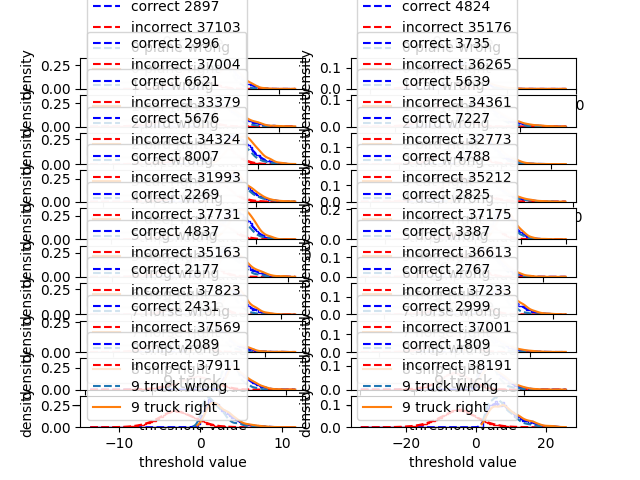

In [65]:
#import helper.graphs as hp
%matplotlib widget
from importlib import reload
reload(hp)

early_exit = classes_grouped[0]
# print(early_exit[0])

fig, ax_grp = plt.subplots(nrows=10,ncols=2)
for k, ex in enumerate(classes_grouped):
    for i, rec_class in enumerate(ex):

      ax = ax_grp[i][k]
      
      rec_class = np.array(rec_class)
      
      # plot all values produce by single class output
      hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None)
    
      wrong_class = rec_class[np.invert(np.array(rec_class[:,2],dtype=bool))]
      # # hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None, right_col='green', wrong_col='orange')
      ismax = np.array(wrong_class[:,1]) == i
      hp.plot_hist_kernel(ax, wrong_class[:,0][ismax], label=f"{i} {classes_labels[i]} wrong", hist=False)
      right_class = rec_class[np.array(rec_class[:,2],dtype=bool)]
      # # hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None, right_col='green', wrong_col='orange')
      ismax = np.array(right_class[:,1]) == i
      hp.plot_hist_kernel(ax, right_class[:,0][ismax], label=f"{i} {classes_labels[i]} right", hist=False, ls='-')
      ax.set_title(f"{i} {classes_labels[i]}")
      ax.legend()
plt.show()

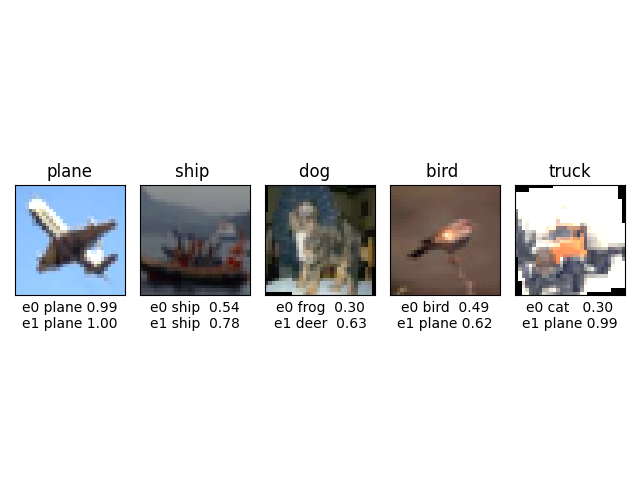

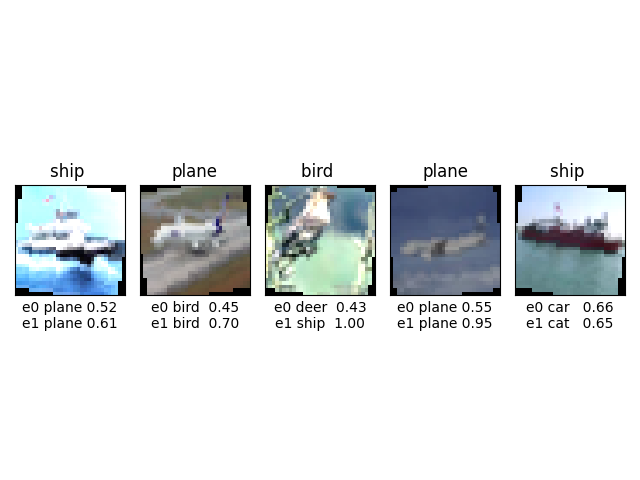

In [75]:
# SHOW THE MODEL WORKING
# %matplotlib ipympl needs ipywidgets
import math
from IPython.core.debugger import set_trace

test_dl = datacoll.get_train_dl()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, ncols=1, label=None, caption=None):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.to('cpu').numpy()
    num_img = npimg.shape[0]
    
    nrows = math.ceil(num_img / ncols)
    
    img_track = 0
    
    for row in range(nrows):
        fig, axs = plt.subplots(nrows=1, ncols=ncols,
                                subplot_kw={'xticks': [], 'yticks': []})

        if row > 5:
            break
        
        for ax in axs:
            if img_track < num_img:
                ax.imshow(np.transpose(npimg[img_track], (1, 2, 0)))
                if label is not None:
                    ax.set_title(label[img_track])
                if caption is not None:
                    ax.set_xlabel(caption[img_track])
            img_track += 1
            
        plt.tight_layout()
        # plt.imshow(np.transpose(npimg, (1, 1, 1)))
        plt.show()

def getcaption(images, model):
    model.eval()
    #captions = ['' for i in range(BATCH_SIZE)]
    captions = ['' for i in range(10)]
    with torch.no_grad():
        result = model.forward(images)
        sftmx = torch.max(torch.softmax(result, dim=-1),dim=-1).values
        res_max = result.max(dim=-1).values
        res_arg_max = result.max(dim=-1).indices
        for exit_num, (max, arg_max) in enumerate(zip(sftmx, res_arg_max)):
            for i, (max_val, index) in enumerate(zip(max, arg_max)):
                captions[i] += f"e{exit_num} {classes[index]:5s} {max_val:.02f}"
                if exit_num != model.exit_num - 1:
                    captions[i] += '\n'
    return captions
# get some random training images
dataiter = iter(test_dl)
images, labels = next(dataiter)
images.shape, labels.shape
images[:10].shape, labels[:10]

images = images[:10].to('cuda:0')
labels = labels[:10].to('cuda:0')


# show images
imshow(images, ncols=5, label=[f'{classes[label]:5s}' for label in labels], caption=getcaption(images, model))
